# Introduction 

In this project we design and cmpare several models for detecting different kinds of toxic comments in a dataset of comments from Wikipedia’s talk page edits. Each sample in the dataset includes a comment and 6 binary values which are human labels on the type(s) of toxicity of the comment. The toxicity types are: toxic, severe_toxic, obscene, threat, insult and identity_hate. A comment may have several labels.

We will develope three types of model: decision tree models (random forest, and boosted trees implemented in XGboost and lightGBM) trained on *term-frequency-inverse-document-frequency (tf-idf)* of the texts, a neural network with an embedding layer followed by a convolutional and dense layer, and a neural network with an embedding layer followed by two GRU layers and a dense layer. In addition, we will examine if using the *Glove* representation [[1]](#glove) of the words as features will improve the perfomance of these models.

# Dataset 

The dataset can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). The data is divided into a train and a test set . There are 159571 samples in the train set and 153164 samples in the test set. The labels for the test set are not provided. But we can evaluate the performance by submitting the predictions to the [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) website of the challange corresponding this dataset which will evaluate the performance on the test set.

We have implemented all the code as a python package named `toxic`. This includes a class named `Toxic` which has several methods for loading and cleaning data and feature extraction. Throughout this report we will explain each method used.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from toxic.base import Toxic, toxic_config
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
tox = Toxic()
tox.loadData(textType='raw')

Fri Jun  1 09:20:11 2018...loading data into pandas df...


`loadData()` method loads the data into the attributes `tox.trainData` and `tox.testData`. These are pandas `DataFrame`.

In [6]:
tox.trainData.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
31860,54a0bb8e5e2e3de1,"Sir, can you please help me with my solution. ...",0,0,0,0,0,0
55514,945c9f767e5fe360,I think they're very outdated. Think it's wort...,0,0,0,0,0,0
151547,7ef790d4bbbb0a93,"""\nRe the definition of what is obsolete, that...",0,0,0,0,0,0
88137,ebc6b4f2832f0a39,i find this very disrespectful to the gaming c...,0,0,0,0,0,0
74714,c7dc8a60cf4bd953,Is there an easy way to block the entire .tk d...,0,0,0,0,0,0


In [7]:
tox.trainData.count()

id               159571
comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
dtype: int64

As we can see, there is not missing value in the data. Next, we compute the number of samples in each class:

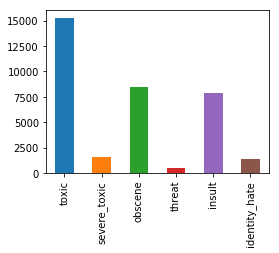

In [14]:
fig=plt.figure(figsize=(4,3));
tox.trainData.iloc[:,2:].sum().plot.bar();

The calsses are highly imbalanced. 124473 of the comments are *normal* (do not belong to any of these six categories).  `toxic` has the highest frequency and `threat` has the lowest. Since the classes are imbalanced, accuracy is not a reasonable measure of performance and we will use area-under-curve (AUC) to compare the performance of different models.

Next, we visualize the correlation between classes:

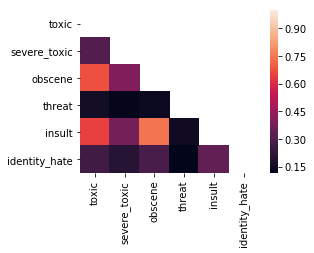

In [19]:
fig=plt.figure(figsize=(4,3));
corr=tox.trainData.iloc[:,2:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask);

`toxic` has the lowest correlation with other classes. `insult` and `obscene` have the highest correlation.

Before proceeding furthur we need to clean the comments. Them method `cleanData` removes all non-characters from the comments. It also gives the option to remove the stop-words. However, our preliminary results showed that excluding stop-words will cause lower performance and so we keep them in the data.

# Models 

We can think of at least two classes of models for text classification. In one class of models, each sample texts is  represented by a bag of words type of features. In this representation, the order of the words is lost. In contrast, the second class of models consider the dynamic nature of the text and so try to model the text as a sequence of words (or their embedding). Here, we consider both types of models and text representations. We train 3 models on the tf-idf representation of the texts: a naive Bayes multinomial model, a random forest and a gradient bossted tree. We also fit two dynamic models: a neural network with a temporal convolutional layer and a neural network with GRU layers. Finally, we will examine if adding the Glove embedding features pre-trained on a large corpus, will improve the performance of the neural network models.

## Multinomial Naive Bayes with tfidf faetues

This is the simplest model and we use its performance as the baseline for comparting other models. We use tf-idf of the texts as the features. We compute tf-idf for words, and 3- and 4-grams of the characters. The method `loadOrCompute_tfidf` of the `Toxic` class uses `TfidfVectorizer` function in sklearn to perform these computations.

In [14]:
#===load packages===
from time import ctime
from os.path import join
from scipy.sparse import load_npz
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.multioutput import MultiOutputClassifier
#===load packages===

#===load feature and target values===
dataDir = '/home/arash/datasets/Kaggle/Toxic'
X_train = load_npz(join(dataDir,'train_tfidf_dict_size_20000.npz'))
X_test = load_npz(join(dataDir,'test_tfidf_dict_size_20000.npz'))
Y_train=np.fromfile(join(dataDir,'Y_train'),'int8').reshape((-1,6))
#===load feature and target values===

#===grid search over alpha===
mnb = MultiOutputClassifier(MultinomialNB())
param_grid={'estimator__alpha': np.logspace(-3,1,10)}
clf = GridSearchCV(mnb,param_grid=param_grid,
                   scoring=make_scorer(roc_auc_score,needs_threshold=True))
clf.fit(X_train,Y_train)
df=pd.DataFrame(clf.cv_results_)
df
#===grid search over alpha===


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_estimator__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.403286,0.490825,0.945167,0.985632,0.001,{u'estimator__alpha': 0.001},7,0.949438,0.985379,0.942400,0.985884,0.943664,0.985633,0.001325,0.000471,0.003064,0.000206
1,1.476180,0.511075,0.950666,0.985026,0.00278256,{u'estimator__alpha': 0.0027825594022071257},5,0.955003,0.984759,0.947940,0.985300,0.949056,0.985019,0.058532,0.005603,0.003100,0.000221
2,1.507239,0.511628,0.955831,0.984225,0.00774264,{u'estimator__alpha': 0.007742636826811269},4,0.960169,0.983933,0.953175,0.984530,0.954150,0.984211,0.046549,0.013141,0.003093,0.000244
3,1.430576,0.491431,0.959990,0.983066,0.0215443,{u'estimator__alpha': 0.021544346900318832},2,0.964093,0.982717,0.957487,0.983426,0.958391,0.983055,0.029379,0.001516,0.002925,0.000290
4,1.414461,0.491405,0.961997,0.980990,0.0599484,{u'estimator__alpha': 0.05994842503189409},1,0.965745,0.980506,0.959604,0.981457,0.960641,0.981006,0.016500,0.000970,0.002684,0.000388
5,1.472594,0.516440,0.959624,0.975881,0.16681,{u'estimator__alpha': 0.1668100537200059},3,0.963214,0.975064,0.957186,0.976643,0.958473,0.975935,0.063786,0.019757,0.002592,0.000646
6,1.485177,0.511895,0.948841,0.962518,0.464159,{u'estimator__alpha': 0.46415888336127775},6,0.952521,0.960992,0.946411,0.963752,0.947590,0.962809,0.048423,0.014200,0.002646,0.001145
7,1.503350,0.505790,0.925501,0.935874,1.29155,{u'estimator__alpha': 1.2915496650148828},8,0.929543,0.933655,0.923170,0.937393,0.923790,0.936573,0.063010,0.019299,0.002869,0.001604
8,1.473361,0.514466,0.889846,0.896685,3.59381,{u'estimator__alpha': 3.593813663804626},9,0.894346,0.894098,0.887417,0.898279,0.887774,0.897679,0.051041,0.014419,0.003186,0.001846
9,1.493977,0.522977,0.849323,0.853293,10,{u'estimator__alpha': 10.0},10,0.854040,0.850717,0.846438,0.855006,0.847490,0.854155,0.069695,0.038219,0.003363,0.001854


So the optimal value is `alpha=0.059`. We re-fit the model with this parameter to the whole data:

In [13]:
clf = clf.best_estimator_.fit(X_train,Y_train)
Y_test = np.hstack([x[:,[1]] for x in clf.predict_proba(X_test)])

The roc_auc score of this model on the test data is **0.9570**. We use this as the baseline score and compare other models to this baseline.

## Gaussian Naive Bayes with Glove features

This model also uses the naive Bayes classifier. However, it uses different features than the previous model. Here, we represent each sample text as a vector which is obtained by averaging the Glove vector representation of the words of that text. To compute these features we use the method `Toxic.loadOrComputeAvgGlove()`. This function, builds a neural network with one embedding layer and one output layer. The input to the network are the texts represented as word sequences. The weights of the embedding layer are the Glove weights pre-trained on a 2014 dump of English Wikipedia (which can be dowloaded from [here](http://nlp.stanford.edu/data/glove.6B.zip)). The output of the embedding layer is fed into a `keras.AveragePooling1D` layer which computes the average of the glove features for each text.

Since the features are continuous we use Gaussian naive Bayes classifier.

In [5]:
#===load packages===
from time import ctime
from os.path import join
from scipy.sparse import load_npz
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from toxic.base import Toxic
#===load packages===

#===load feature and target values===
tox = Toxic()
tox.loadOrComputeAvgGlove(embed_dim=50,dict_size=20000,max_seq_len=50,
                          loadOrCompute='load')
Y_train=np.fromfile(join(tox.dataDir,'Y_train'),'int8').reshape((-1,6))
#===load feature and target values===

#===build and fit the model===
gnb=MultiOutputClassifier(GaussianNB())
gnb=gnb.fit(tox.trainFeatureMat,Y_train)
#===build and fit the model===

In [7]:
Y_test = np.hstack([x[:,[1]] for x in gnb.predict_proba(tox.testFeatureMat)])

The AUC on the test set is **0.8645**. So this model performs very poorly. The reason could be the Gaussian NB classifier or poor features. Since the average Glove features could take negative values we cannot use the multinomial NB classifier. To examine the effect of the classfier, later we will use the average Glove features with the boosted tree classifiers. 

# References 

<a id='glove'></a> 1. Pennington, J., Socher, R., & Manning, C. (2014). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP) (pp. 1532-1543).